In [188]:
import cobra
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm, Normalize
import hdbscan
from pathlib import Path
sns.set_theme(font_scale = 1, style = 'ticks')



In [189]:
figure_folder = Path('../../../SupplementalFigures')

In [190]:
model_fn = "../../../models/e_coli/momentiJO1366.xml"
model = cobra.io.read_sbml_model(model_fn)

In [191]:
for r in model.exchanges:
    r.lower_bound = 0


In [192]:
# M9
uptake = ['EX_glc__D_e', 'EX_nh4_e', 'EX_pi_e', 'EX_so4_e', 'EX_h2o_e', 'EX_h_e', 'EX_o2_e', 'EX_fe2_e', 'EX_fe3_e', 'EX_cobalt2_e', 'EX_ca2_e', 'EX_cl_e', 
       'EX_cu2_e','EX_k_e', 'EX_mg2_e', 'EX_mn2_e','EX_zn2_e', 'EX_mobd_e', 'EX_ni2_e', 'EX_na1_e']


# model.add_boundary(model.metabolites.na1_e, 'exchange', lb = -1000, ub = 1000)
# model.add_boundary(model.metabolites.ni2_e, 'exchange', lb = -1000, ub = 1000)
for r_id in uptake:
    model.reactions.get_by_id(r_id).lower_bound = -1000
print(model.optimize())

<Solution 0.743 at 0x3101285b0>


In [193]:
carbon_compounds = []
model.reactions.EX_glc__D_e.lower_bound = 0
for r in model.exchanges:
    with model:
        model.reactions.get_by_id(r.id).bounds = (-10,1000)
        sol = model.slim_optimize()
        if sol > 0:
            carbon_compounds.append(r.id)

In [194]:
Nc = len(carbon_compounds)
fluxes = np.zeros((Nc, len(model.reactions)))
for i in range(Nc):
    with model:
        r_id = carbon_compounds[i]
        model.reactions.get_by_id(r_id).bounds = (-10,1000)
        solution = cobra.flux_analysis.pfba(model)
        fluxes[i,:] = solution.fluxes

In [195]:
# Ignore some long fatty acid chains that are not realistic
ignore = ['EX_ade_e',
        'EX_alltn_e',
        'EX_amp_e',
        'EX_dgsn_e',
        'EX_din_e',
        'EX_g3ps_e',
        'EX_gua_e',
        'EX_hxa_e',
        'EX_hxan_e',
        'EX_octa_e',
        'EX_ppal_e',
        # 'EX_sbt__D_e',
        'EX_xmp_e',
        'EX_xtsn_e',
        'EX_dca_e',
        'EX_ddca_e',
        'EX_hdca_e',
        'EX_hdcea_e',
        'EX_ocdca_e',
        'EX_ocdcea_e',
        'EX_ttdca_e',
        'EX_ttdcea_e',
        'EX_adn_e',
        'EX_dad_2_e',
        'EX_damp_e',
        'EX_dgmp_e',
        'EX_dimp_e',
        'EX_imp_e',
        'EX_ins_e',
        'EX_23camp_e',
        'EX_23cgmp_e',
        'EX_3amp_e',
        'EX_3gmp_e',
        'EX_gmp_e',
        'EX_gsn_e',
        'EX_xan_e',
        'EX_12ppd__S_e',
        'EX_23dappa_e',
        'EX_3hcinnm_e',
        'EX_3hpppn_e',
        'EX_malthx_e',
        'EX_maltpt_e',
        'EX_malttr_e',
        'EX_maltttr_e']
keep_idxs = [i for i,x in enumerate(carbon_compounds) if not x in ignore]
fluxes = fluxes[keep_idxs, :]

# Cluster fluxes

In [196]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import DBSCAN
import scipy.cluster.hierarchy as spc
from sklearn.mixture import GaussianMixture


In [197]:
corr = np.corrcoef(fluxes)
pdist = spc.distance.pdist(corr)

In [198]:
linkage = spc.linkage(pdist, method='complete')
idx = spc.fcluster(linkage, 2, 'distance')
print(len(np.unique(idx)))

5


In [199]:
nz_fluxes = fluxes[:, ~(fluxes==0).all(axis =0)]

In [200]:
binary_fluxes = np.sign(nz_fluxes)
bf2 = binary_fluxes[:, ~(binary_fluxes.std(axis =0) == 0)]

In [201]:
standard_scaler = StandardScaler()
sd_fluxes = standard_scaler.fit_transform(nz_fluxes)
# sd_fluxes[508,:].mean()

In [202]:
fluxes.var(axis=0)

array([1.33837009e-09, 1.36262146e-09, 0.00000000e+00, ...,
       3.12950216e-09, 0.00000000e+00, 4.67548114e-05])

# Selected carbon sources

In [203]:
metabolites = []
metabolite_ids = []
s_carbon_compounds = np.array(carbon_compounds)[keep_idxs]
for r_id in s_carbon_compounds:
    r = model.reactions.get_by_id(r_id)
    m, i = r.metabolites.popitem()
    metabolites.append(m.name)
    metabolite_ids.append(m.id)


In [209]:
len(metabolites)

104

In [205]:
selected_cs = ['L-Malate', 'D-Glucose', 'D-Galactose', 'Glycine', 'L-Alanine', 
            "L-Arginine", 'L-Aspartate', 'L-Lactate','D-Xylose', 'D-Ribose', 'D-Mannose']
print(len(selected_cs))

11


[3] L-Malate
[2] D-Glucose
[0] D-Galactose
[4] Glycine
[1] L-Alanine
[1] L-Arginine
[1] L-Aspartate
[3] L-Lactate
[2] D-Xylose
[0] D-Ribose
[0] D-Mannose


/Users/snorre/miniconda3/envs/reframed/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/snorre/miniconda3/envs/reframed/lib/python3.9/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_16228/2748173886.py:6: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(t[:,0], t[:,1], c = 'g' , cmap = 'tab10', alpha = 0.5)#c = clusterer.labels_


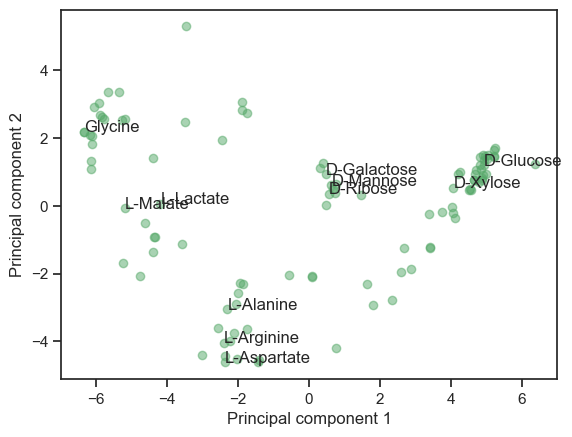

In [206]:
pca = PCA(n_components=2)
t = pca.fit_transform(bf2)

clusterer = hdbscan.HDBSCAN()
clusterer.fit(t)
plt.scatter(t[:,0], t[:,1], c = 'g' , cmap = 'tab10', alpha = 0.5)#c = clusterer.labels_
plt.xlabel('Principal component 1')
plt.ylabel('Principal component 2')

for cs in selected_cs:
    idx = [i for i, x in enumerate(metabolites) if x == cs]
    print(clusterer.labels_[idx], cs)
    plt.annotate(cs, (t[idx,0], t[idx,1]))

# Plot only final selection

In [207]:
met_to_label = {
    'L-Malate': 'Malate',
    'D-Glucose': 'Glucose',
    'D-Galactose': 'Galactose',
    'Glycine': 'Glycine',
    'D-Ribose': 'Ribose',
    'D-Mannose': 'Mannose',
    'L-Alanine': 'L-alanine',
    "L-Arginine": "L-arginine",
    'L-Aspartate': 'L-aspartate',
    'L-Lactate': 'Lactate',
    'D-Xylose': 'Xylose'
}

104


/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_16228/3584569925.py:11: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  ax.scatter(t[i,0], t[i,1], c = cmap[j],


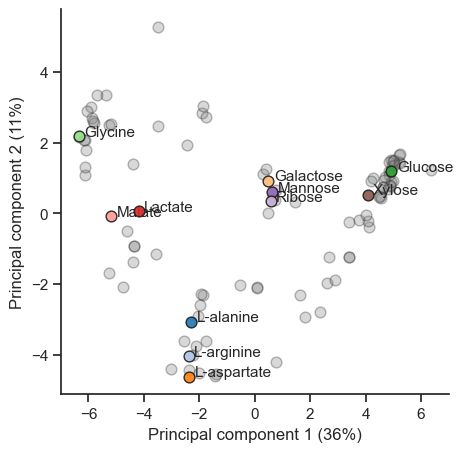

In [208]:
pca = PCA(n_components=2)
t = pca.fit_transform(bf2)
cmap = sns.color_palette('tab20', 20)# finally_se
fig, ax = plt.subplots(figsize=(5, 5))
j = 0
print(len(metabolites))
cs_to_color = {}
for i, met in enumerate(metabolites):

    if met in selected_cs:
        ax.scatter(t[i,0], t[i,1], c = cmap[j],
                s = 60, edgecolor = 'k', linewidth = 1,
                alpha = 0.9, zorder = 100)
        ax.annotate(met_to_label[met], (t[i,0]+0.2, t[i,1]), fontsize = 11)
        cs_to_color[met_to_label[met]] = cmap[j]
        j+=1

    else:
        ax.scatter(t[i,0], t[i,1], c = 'gray' ,
                s = 60, edgecolor = 'k', linewidth = 1,
                alpha = 0.3)#c = clusterer.labels_
    
plt.xlabel(f'Principal component 1 ({100*pca.explained_variance_ratio_[0]:.0f}%)', size = 12)
plt.ylabel(f'Principal component 2 ({100*pca.explained_variance_ratio_[1]:.0f}%)', size = 12)
sns.despine()
plt.savefig(figure_folder / 'PCA_cs_screen.pdf', bbox_inches='tight')
# plt.savefig(figure_folder / 'PCA_cs_screen.png', bbox_inches='tight', dpi = 300)

In [158]:
sns.color_palette('tab20')

[(0.12156862745098039, 0.4666666666666667, 0.7058823529411765),
 (0.6823529411764706, 0.7803921568627451, 0.9098039215686274),
 (1.0, 0.4980392156862745, 0.054901960784313725),
 (1.0, 0.7333333333333333, 0.47058823529411764),
 (0.17254901960784313, 0.6274509803921569, 0.17254901960784313),
 (0.596078431372549, 0.8745098039215686, 0.5411764705882353),
 (0.8392156862745098, 0.15294117647058825, 0.1568627450980392),
 (1.0, 0.596078431372549, 0.5882352941176471),
 (0.5803921568627451, 0.403921568627451, 0.7411764705882353),
 (0.7725490196078432, 0.6901960784313725, 0.8352941176470589),
 (0.5490196078431373, 0.33725490196078434, 0.29411764705882354),
 (0.7686274509803922, 0.611764705882353, 0.5803921568627451),
 (0.8901960784313725, 0.4666666666666667, 0.7607843137254902),
 (0.9686274509803922, 0.7137254901960784, 0.8235294117647058),
 (0.4980392156862745, 0.4980392156862745, 0.4980392156862745),
 (0.7803921568627451, 0.7803921568627451, 0.7803921568627451),
 (0.7372549019607844, 0.7411764705882353, 0.13333333333333333),
 (0.8588235294117647, 0.8588235294117647, 0.5529411764705883),
 (0.09019607843137255, 0.7450980392156863, 0.8117647058823529),
 (0.6196078431372549, 0.8549019607843137, 0.8980392156862745)]

# Now read in growth data

In [159]:
data_folder = Path("../../../data/this_project/1_e_coli_batch_cultures/")
od_data = data_folder / '1L_ecoli_cs_screen_OD.csv'
od_df = pd.read_csv(od_data)

In [160]:
od_df['Carbon source'] = od_df['Carbon source'].str.capitalize()

In [161]:
od_df['Carbon source'].replace(
    
)

/var/folders/xf/kl76knj11y72v0_qy4vv7tgh0000gp/T/ipykernel_16228/1750509688.py:1: FutureWarning: Series.replace without 'value' and with non-dict-like 'to_replace' is deprecated and will raise in a future version. Explicitly specify the new values instead.
  od_df['Carbon source'].replace(


0       Galactose
1       Galactose
2       Galactose
3       Galactose
4       Galactose
          ...    
4924      Lactate
4925      Lactate
4926      Lactate
4927      Lactate
4928      Lactate
Name: Carbon source, Length: 4929, dtype: object

In [162]:
od_cs_to_label = {
    'L-malate': 'Malate',
    'Glucose': 'Glucose',
    'Galactose': 'Galactose',
    'Glycine': 'Glycine',
    'L-Alanine': 'L-alanine',
    "L-arginine": "L-arginine",
    'L-aspartate': 'L-aspartate',
    'Lactate': 'Lactate',
    'Xylose': 'Xylose',
    'Ribose': 'Ribose',
    'Mannose': 'Mannose',

}

In [163]:
od_df['Carbon source'] = od_df['Carbon source'].map(od_cs_to_label)

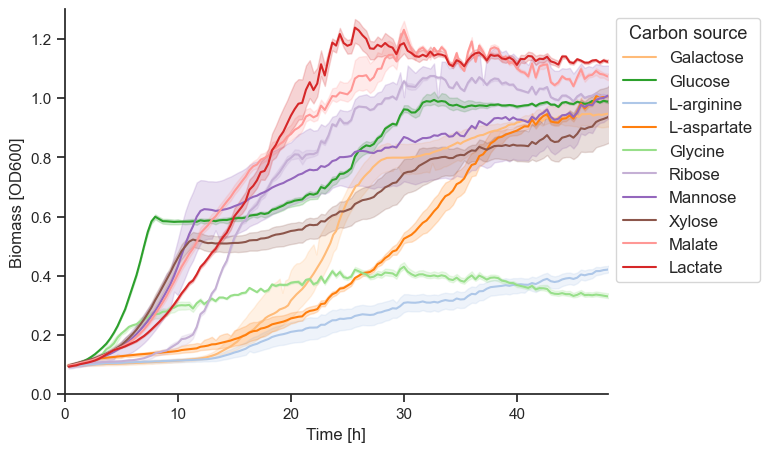

In [165]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.lineplot(data = od_df, x = 'Hours', y = 'OD600', hue = 'Carbon source', palette = cs_to_color,ax=ax)
plt.xlabel('Time [h]', size = 12)
plt.ylabel('Biomass [OD600]', size = 12)
ax.set_xlim(0, 48)
ax.set_ylim(0, 1.3)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), title = 'Carbon source', fontsize = 12, title_fontsize = 13)
sns.despine()
plt.savefig(figure_folder / 'OD_cs_screen.pdf', bbox_inches='tight')


In [19]:
pca.explained_variance_
print(bf2.shape, Nc)

(104, 767) 147


[3] L-Malate
[2] D-Glucose
[0] D-Galactose
[4] Glycine
[3] Fumarate
[1] L-Alanine
[1] Succinate
[1] L-Arginine
[-1] L-Glutamine
[1] L-Aspartate
[2] D-Fructose


Text(0, 0.5, 'tSNE 2')

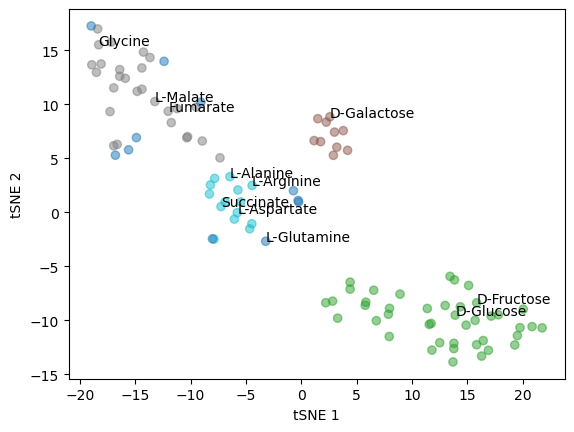

In [20]:
# X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=15).fit_transform(sd_fluxes)
X_embedded = TSNE(n_components=2, learning_rate='auto',init='random', perplexity=15).fit_transform(bf2)
# clustering = DBSCAN(eps=2, min_samples=2 ).fit(X_embedded)
tsne_clust = hdbscan.HDBSCAN()
tsne_clust.fit(X_embedded)
plt.scatter(X_embedded[:,0], X_embedded[:,1], c = tsne_clust.labels_, cmap = 'tab10', alpha = 0.5)
# len(np.unique(clustering.labels_))
# for i, row in df_sel.iterrows():
#     met = row['Metabolite ID']
#     try:
#         idx = met_index_dict[met]
#     except:
#         print(met)
#         pass
#     else:
#         plt.annotate(row['Metabolite'], (X_embedded[idx,0], X_embedded[idx,1]))
for cs in selected_cs:
    idx = [i for i, x in enumerate(metabolites) if x == cs]
    print(clusterer.labels_[idx], cs)
    plt.annotate(cs, (X_embedded[idx,0], X_embedded[idx,1]))
    
plt.xlabel('tSNE 1')
plt.ylabel('tSNE 2')

In [21]:
df = pd.DataFrame()
df['Exchange'] = s_carbon_compounds
df['PCA cluster'] = clusterer.labels_
df['tSNE cluster'] = tsne_clust.labels_
df['Metabolite'] = metabolites
df['Metabolite ID'] = metabolite_ids
df.to_csv('carbon_compounds_clustered.csv')

In [137]:
len(np.array(carbon_compounds)[keep_idxs])

139

## PCoA

In [58]:
import skbio

In [38]:
nc = len(s_carbon_compounds)
J = np.zeros((nc,nc))
bfabs = np.abs(bf2).astype(bool)
for i in range(nc):
    for j in range(nc):
        J[i,j] = 1np.sum(bfabs[i,:]*bfabs[j,:])/np.sum(bfabs[i,:]+bfabs[j,:])
    

In [59]:
orden = skbio.stats.ordination.pcoa(J, number_of_dimensions=2)


/Users/ssulheim/anaconda3/lib/python3.11/site-packages/skbio/stats/ordination/_principal_coordinate_analysis.py:143: RuntimeWarning: The result contains negative eigenvalues. Please compare their magnitude with the magnitude of some of the largest positive eigenvalues. If the negative ones are smaller, it's probably safe to ignore them, but if they are large in magnitude, the results won't be useful. See the Notes section for more details. The smallest eigenvalue is -0.12452167918910903 and the largest is 4.827013345561654.
  warn(


In [65]:
X.shape

(104, 2)

[2] L-Malate
[6] D-Glucose
[0] D-Galactose
[3] Glycine
[2] Fumarate
[1] L-Alanine
[1] Succinate
[1] L-Arginine
[-1] L-Glutamine
[1] L-Aspartate
[-1] D-Fructose


/var/folders/h6/4b_zz_cd5d92w2ycp017ytn00000gp/T/ipykernel_35440/1182348697.py:4: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  plt.scatter(X[:,0], X[:,1], c = 'g' , cmap = 'tab10', alpha = 0.5)#c = clusterer.labels_


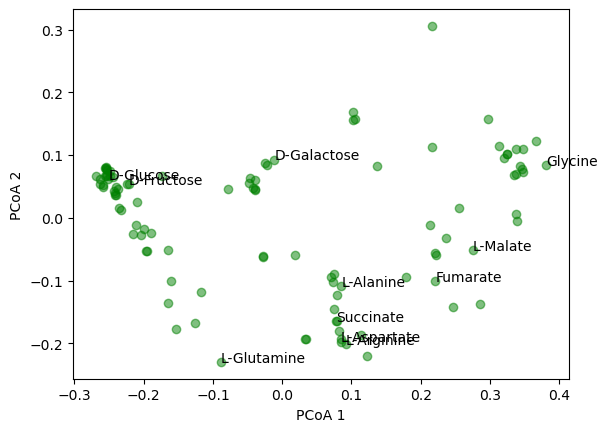

In [66]:
clusterer = hdbscan.HDBSCAN()
X = np.array(orden.samples)
clusterer.fit(orden.samples)
plt.scatter(X[:,0], X[:,1], c = 'g' , cmap = 'tab10', alpha = 0.5)#c = clusterer.labels_
plt.xlabel('PCoA 1')
plt.ylabel('PCoA 2')

for cs in selected_cs:
    idx = [i for i, x in enumerate(metabolites) if x == cs]
    print(clusterer.labels_[idx], cs)
    plt.annotate(cs, (X[idx,0], X[idx,1]))

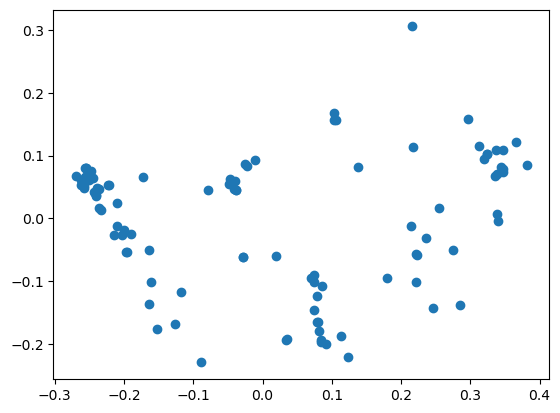

In [57]:
plt.scatter(orden.samples['PC1'], orden.samples['PC2'])